In [14]:
from keras.datasets import boston_housing

In [15]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [16]:
train_data.shape

(404, 13)

In [17]:
test_data.shape

(102, 13)

# 准备数据

In [18]:
# 数据标准化

In [19]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

In [20]:
test_data -= mean
test_data /= std

# 构建网络

In [21]:
from keras import models
from keras import layers

In [22]:
# 需要将同一个模型多次实例化，所以用一个函数来构建模型

In [28]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(units=64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(units=64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

# 利用K折交叉验证来验证该方法

In [29]:
import numpy as np

In [30]:
k = 4
num_val_samples = len(train_data) // k  # //表示取整，即返回商的整数部分
num_epochs = 100
all_scores = []

In [32]:
for i in range(k):
    print('Processing flod #', i)
    # 准备验证数据：第k个分区数据
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i *num_val_samples: (i + 1) * num_val_samples]
    # 准备训练数据：其他所有分区的数据
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],axis=0)
    # 构建Keras模型（已编译）
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)  # 静默模式verbose=0
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)  # 在验证集上评估模型
    all_scores.append(val_mae)

Processing flod # 0
Processing flod # 1
Processing flod # 2
Processing flod # 3


In [33]:
all_scores

[2.3295871243618502, 2.265496362553965, 3.0113189621727066, 2.413770221837676]

In [34]:
np.mean(all_scores)  # 平均绝对误差

2.5050431677315497

# 保存每折的验证结果

In [35]:
num_epochs = 500
all_mae_histories = []

In [36]:
for i in range(k):
    print('Processing flod #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

Processing flod # 0
Processing flod # 1
Processing flod # 2
Processing flod # 3


# 计算所有轮次中的K折验证分数平均值

In [37]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

In [39]:
average_mae_history

[4.796260057109418,
 3.388253514129336,
 3.0613692880857104,
 2.7477962203545143,
 2.8000500544463054,
 2.702017045257115,
 2.642657151316652,
 2.632763185123406,
 2.5626519623369273,
 2.5882294095388736,
 2.4941609602163335,
 2.7348955716236985,
 2.5149962158486394,
 2.401639177067445,
 2.429407354628686,
 2.4309913238676466,
 2.477810794764226,
 2.4454405071711776,
 2.365843332640015,
 2.4989384589809003,
 2.3823630986827435,
 2.34677781799052,
 2.3206379862114934,
 2.338277532322572,
 2.502779268982387,
 2.338780143473408,
 2.287129287672515,
 2.413876928905449,
 2.3147823987620892,
 2.4469648103902832,
 2.359624257182131,
 2.475844658247315,
 2.3268122968107168,
 2.44396447427202,
 2.4180243770674905,
 2.2758108082384165,
 2.3691625772136273,
 2.3232234421342906,
 2.306444499752309,
 2.37565416569757,
 2.2684173749224974,
 2.3048877963925354,
 2.2882128304774216,
 2.2937845983127554,
 2.221562161303983,
 2.467723325927659,
 2.296288751139499,
 2.3318388131585452,
 2.337362637614259

In [41]:
len(average_mae_history)

500

# 绘制验证分数

In [42]:
import matplotlib.pyplot as plt

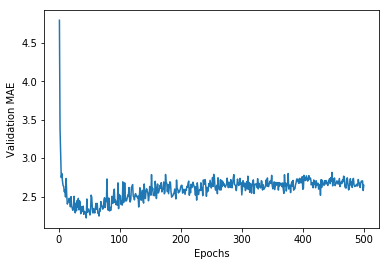

In [43]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# 绘制验证分数（删除前十个点，并将数据点替换为前面数据点的指数移动平均）

In [44]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [45]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

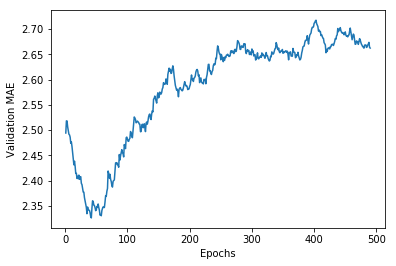

In [46]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [47]:
# 验证MAE在80轮后不再显著降低，之后开始过拟合

# 调参后，使用最佳参数训练模型

In [48]:
model = build_model()

In [49]:
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)

In [50]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

 32/102 [========>.....................] - ETA: 0s

In [51]:
test_mae_score

2.695051155838312

In [52]:
# 预测的与实际价格相差约2695美元